<a href="https://colab.research.google.com/github/Nguyen-The-Thanh/NguyenTheThanh_training_FMlab/blob/main/Ex/Ex13/TrainingDNNs2_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks (Tiếp)
Trong buổi này, chúng ta tiếp tục làm quen với một số kỹ thuật huấn luyện mạng nơ-ron

In [1]:
!nvidia-smi

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

Sat Nov  1 23:38:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 1. Cài đặt BatchNorm

In [3]:
def compare_bn(bn1, bn2):
    err = False
    if not torch.allclose(bn1.running_mean, bn2.running_mean):
        print('Diff in running_mean: {} vs {}'.format(
            bn1.running_mean, bn2.running_mean))
        err = True

    if not torch.allclose(bn1.running_var, bn2.running_var):
        print('Diff in running_var: {} vs {}'.format(
            bn1.running_var, bn2.running_var))
        err = True

    if bn1.affine and bn2.affine:
        if not torch.allclose(bn1.weight, bn2.weight):
            print('Diff in weight: {} vs {}'.format(
                bn1.weight, bn2.weight))
            err = True

        if not torch.allclose(bn1.bias, bn2.bias):
            print('Diff in bias: {} vs {}'.format(
                bn1.bias, bn2.bias))
            err = True

    if not err:
        print('All parameters are equal!')


class MyBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1,
                 affine=True, track_running_stats=True):
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)

    def forward(self, input):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3])
            # use biased var in train
            var = input.var([0, 2, 3], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        # Chuẩn hoá input
        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
        if self.affine:
            # Biến đổi input sau khi chuẩn hoá
            input = input * self.weight[None, :, None, None] + self.bias[None, :, None, None]

        return input


# Init BatchNorm layers
my_bn = MyBatchNorm2d(3, affine=True)
bn = nn.BatchNorm2d(3, affine=True)

compare_bn(my_bn, bn)  # weight and bias should be different
# Load weight and bias
my_bn.load_state_dict(bn.state_dict())
compare_bn(my_bn, bn)

# Run train
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)
    print('Max diff: ', (out1 - out2).abs().max())

# Run eval
my_bn.eval()
bn.eval()
for _ in range(10):
    scale = torch.randint(1, 10, (1,)).float()
    bias = torch.randint(-10, 10, (1,)).float()
    x = torch.randn(10, 3, 100, 100) * scale + bias
    out1 = my_bn(x)
    out2 = bn(x)
    compare_bn(my_bn, bn)

    torch.allclose(out1, out2)

All parameters are equal!
All parameters are equal!
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
Max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are equal!
All parameters are

### 2. Cài đặt chiến lược thay đổi tốc độ học: Warm-up + Cosine Annealing LR

In [24]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [25]:
trainset, testset = load_data('./data')
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
)

epochs = 30
warm_epoch = 5
init_lr = 1e-1
last_lr = 1e-5
T_max = epochs
T_cur = 0
lr_list = [0]

net = Net()
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=init_lr, momentum=0.9)

In [26]:
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_steps = 0
    T_cur += 1

    # warm-up and cosine annealing lr
    if epoch <= warm_epoch:
      optimizer.param_groups[0]['lr'] = (1.0 * epoch) / warm_epoch * init_lr
    else:
    # cosine annealing lr
      optimizer.param_groups[0]['lr'] = last_lr + (init_lr - last_lr) * (1 + np.cos(T_cur * np.pi / T_max)) / 2


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i + 1 == len(trainloader):
            print("[Epoch %d] loss: %.3f" % (epoch, running_loss / epoch_steps))
            running_loss = 0.0

    lr_list.append(optimizer.param_groups[0]['lr'])

print("Finished Training")

[Epoch 1] loss: 2.302
[Epoch 2] loss: 2.227
[Epoch 3] loss: 2.121
[Epoch 4] loss: 2.105
[Epoch 5] loss: 2.284
[Epoch 6] loss: 2.353
[Epoch 7] loss: 2.358
[Epoch 8] loss: 2.324
[Epoch 9] loss: 2.311
[Epoch 10] loss: 2.322
[Epoch 11] loss: 2.318
[Epoch 12] loss: 2.326
[Epoch 13] loss: 2.324
[Epoch 14] loss: 2.322
[Epoch 15] loss: 2.314
[Epoch 16] loss: 2.302
[Epoch 17] loss: 2.301
[Epoch 18] loss: 2.299
[Epoch 19] loss: 2.299
[Epoch 20] loss: 2.300
[Epoch 21] loss: 2.300
[Epoch 22] loss: 2.301
[Epoch 23] loss: 2.301
[Epoch 24] loss: 2.301
[Epoch 25] loss: 2.297
[Epoch 26] loss: 2.297
[Epoch 27] loss: 2.297
[Epoch 28] loss: 2.297
[Epoch 29] loss: 2.297
[Epoch 30] loss: 2.297
Finished Training


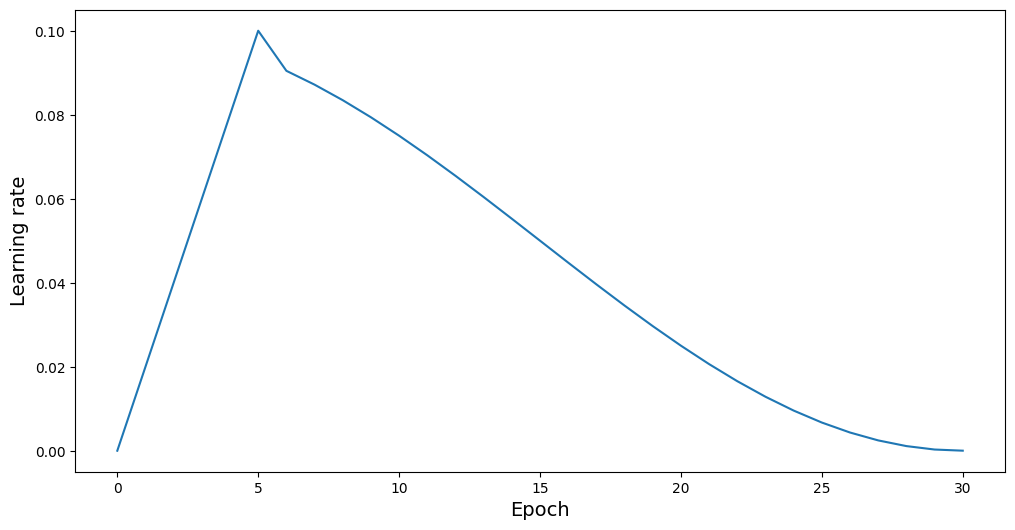

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(lr_list))), lr_list, label="lr")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Learning rate", fontsize=14)
plt.show()

### 3. Tuning siêu tham số

Cài đặt thư viện ray

In [29]:
!pip install ray

In [30]:
import os
from ray.tune import CLIReporter
from ray import tune
from torch.utils.data import random_split
from functools import partial

Viết hàm huấn luyện mô hình nơ-ron trên tập CIFAR10

In [31]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(5):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            print("*"*10, path, "*"*10)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

Lựa chọn siêu tham số tốt (hyperparameter tuning): l1 nhận giá trị 32 hoặc 64, l2 nhận giá trị 32 hoặc 64, lr bằng 1e-4 hoặc 1e-2, batchsize cố định 16

In [32]:
def main(num_samples=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")

    # Liệt kê các giá trị của các siêu tham số cần tìm kiếm
    config = {
        "l1": tune.grid_search([32, 64]),
        "l2": tune.grid_search([16, 32]),
        "lr": tune.grid_search([1e-4, 1e-2]),
        "batch_size": tune.grid_search([16])
    }

    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        progress_reporter=reporter)

main(num_samples=10, gpus_per_trial=1)

2025-11-02 00:34:58,457	WARNING callback.py:143 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2025-11-02 00:34:58,464	WARNING tune.py:902 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+--------------------------------------------------------------------+
| Configuration for experiment     train_cifar_2025-11-02_00-34-58   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 80                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_cifar_2025-11-02_00-34-58

Trial status: 80 PENDING
Current time: 2025-11-02 00:35:00. Total running time: 1s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00000   PENDING 

(func pid=18036) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=18036)   warnings.warn(



Trial status: 1 RUNNING | 79 PENDING
Current time: 2025-11-02 00:35:30. Total running time: 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00000   RUNNING      32     16   0.0001             16 |
| train_cifar_c2c1d_00001   PENDING      64     16   0.0001             16 |
| train_cifar_c2c1d_00002   PENDING      32     32   0.0001             16 |
| train_cifar_c2c1d_00003   PENDING      64     32   0.0001             16 |
| train_cifar_c2c1d_00004   PENDING      32     16   0.01               16 |
| train_cifar_c2c1d_00005   PENDING      64     16   0.01               16 |
+--------------------------------------------------------------------------+
74 more PENDING
(func pid=18036) [1,  2000] loss: 2.303


(func pid=18036) [2025-11-02 00:35:45,319 E 18036 18110] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-02 00:35:45,948	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_c2c1d_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_c2c1d_00000 errored after 0 iterations at 2025-11-02 00:35:45. Total running time: 47s
Error file: /tmp/ray/session_2025-11-01_23-59-00_254750_447/artifacts/2025-11-02_00-34-58/train_cifar_2025-11-02_00-34-58/driver_artifacts/train_cifar_c2c1d_00000_0_batch_size=16,l1=32,l2=16,lr=0.0001_2025-11-02_00-34-58/error.txt

Trial train_cifar_c2c1d_00001 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_c2c1d_00001 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           16 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=18368) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=18368)   warnings.warn(



Trial status: 1 ERROR | 1 RUNNING | 78 PENDING
Current time: 2025-11-02 00:36:00. Total running time: 1min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00001   RUNNING      64     16   0.0001             16 |
| train_cifar_c2c1d_00002   PENDING      32     32   0.0001             16 |
| train_cifar_c2c1d_00003   PENDING      64     32   0.0001             16 |
| train_cifar_c2c1d_00004   PENDING      32     16   0.01               16 |
| train_cifar_c2c1d_00005   PENDING      64     16   0.01               16 |
| train_cifar_c2c1d_00006   PENDING      32     32   0.01               16 |
| train_cifar_c2c1d_00000   ERROR        32     16   0.0001             16 |
+-----------------------------------------

(func pid=18368) [2025-11-02 00:36:24,057 E 18368 18410] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-02 00:36:26,410	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_c2c1d_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_c2c1d_00001 errored after 0 iterations at 2025-11-02 00:36:26. Total running time: 1min 27s
Error file: /tmp/ray/session_2025-11-01_23-59-00_254750_447/artifacts/2025-11-02_00-34-58/train_cifar_2025-11-02_00-34-58/driver_artifacts/train_cifar_c2c1d_00001_1_batch_size=16,l1=64,l2=16,lr=0.0001_2025-11-02_00-34-58/error.txt

Trial status: 2 ERROR | 78 PENDING
Current time: 2025-11-02 00:36:30. Total running time: 1min 31s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00002   PENDING      32     32   0.0001             16 |
| train_cifar_c2c1d_00003   PENDING      64     32   0.0001             16 |
| train_cifar_c2c1d_00004   PENDING      32     16   0.01               16 |
| train_cifar_c2c1d_000

(func pid=18675) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=18675)   warnings.warn(


(func pid=18675) [1,  2000] loss: 2.303

Trial status: 2 ERROR | 1 RUNNING | 77 PENDING
Current time: 2025-11-02 00:37:00. Total running time: 2min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00002   RUNNING      32     32   0.0001             16 |
| train_cifar_c2c1d_00003   PENDING      64     32   0.0001             16 |
| train_cifar_c2c1d_00004   PENDING      32     16   0.01               16 |
| train_cifar_c2c1d_00005   PENDING      64     16   0.01               16 |
| train_cifar_c2c1d_00006   PENDING      32     32   0.01               16 |
| train_cifar_c2c1d_00007   PENDING      64     32   0.01               16 |
| train_cifar_c2c1d_00000   ERROR        32     16   0.0001             16 |
| 

(func pid=18675) [2025-11-02 00:37:04,635 E 18675 18716] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-02 00:37:08,117	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_c2c1d_00002
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_c2c1d_00002 errored after 0 iterations at 2025-11-02 00:37:08. Total running time: 2min 9s
Error file: /tmp/ray/session_2025-11-01_23-59-00_254750_447/artifacts/2025-11-02_00-34-58/train_cifar_2025-11-02_00-34-58/driver_artifacts/train_cifar_c2c1d_00002_2_batch_size=16,l1=32,l2=32,lr=0.0001_2025-11-02_00-34-58/error.txt

Trial train_cifar_c2c1d_00003 started with configuration:
+-------------------------------------------------+
| Trial train_cifar_c2c1d_00003 config            |
+-------------------------------------------------+
| batch_size                                   16 |
| l1                                           64 |
| l2                                           32 |
| lr                                       0.0001 |
+-------------------------------------------------+


(func pid=18988) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=18988)   warnings.warn(



Trial status: 3 ERROR | 1 RUNNING | 76 PENDING
Current time: 2025-11-02 00:37:30. Total running time: 2min 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00003   RUNNING      64     32   0.0001             16 |
| train_cifar_c2c1d_00004   PENDING      32     16   0.01               16 |
| train_cifar_c2c1d_00005   PENDING      64     16   0.01               16 |
| train_cifar_c2c1d_00006   PENDING      32     32   0.01               16 |
| train_cifar_c2c1d_00007   PENDING      64     32   0.01               16 |
| train_cifar_c2c1d_00008   PENDING      32     16   0.0001             16 |
| train_cifar_c2c1d_00000   ERROR        32     16   0.0001             16 |
| train_cifar_c2c1d_00001   ERROR        

(func pid=18988) [2025-11-02 00:37:46,219 E 18988 19034] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-02 00:37:48,459	ERROR tune_controller.py:1331 -- Trial task failed for trial train_cifar_c2c1d_00003
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_private/client_mode_hook.py", line 104, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/_


Trial train_cifar_c2c1d_00003 errored after 0 iterations at 2025-11-02 00:37:48. Total running time: 2min 49s
Error file: /tmp/ray/session_2025-11-01_23-59-00_254750_447/artifacts/2025-11-02_00-34-58/train_cifar_2025-11-02_00-34-58/driver_artifacts/train_cifar_c2c1d_00003_3_batch_size=16,l1=64,l2=32,lr=0.0001_2025-11-02_00-34-58/error.txt

Trial status: 4 ERROR | 76 PENDING
Current time: 2025-11-02 00:38:00. Total running time: 3min 1s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00004   PENDING      32     16   0.01               16 |
| train_cifar_c2c1d_00005   PENDING      64     16   0.01               16 |
| train_cifar_c2c1d_00006   PENDING      32     32   0.01               16 |
| train_cifar_c2c1d_

(func pid=19301) /usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=19301)   warnings.warn(


(func pid=19301) [1,  2000] loss: 2.277


2025-11-02 00:38:22,711	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-11-02 00:38:22,739	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_cifar_2025-11-02_00-34-58' in 0.0254s.



Trial status: 4 ERROR | 1 RUNNING | 75 PENDING
Current time: 2025-11-02 00:38:22. Total running time: 3min 24s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------+
| Trial name                status       l1     l2       lr     batch_size |
+--------------------------------------------------------------------------+
| train_cifar_c2c1d_00004   RUNNING      32     16   0.01               16 |
| train_cifar_c2c1d_00005   PENDING      64     16   0.01               16 |
| train_cifar_c2c1d_00006   PENDING      32     32   0.01               16 |
| train_cifar_c2c1d_00007   PENDING      64     32   0.01               16 |
| train_cifar_c2c1d_00008   PENDING      32     16   0.0001             16 |
| train_cifar_c2c1d_00009   PENDING      64     16   0.0001             16 |
| train_cifar_c2c1d_00010   PENDING      32     32   0.0001             16 |
| train_cifar_c2c1d_00011   PENDING      

(func pid=19301) [2025-11-02 00:38:26,867 E 19301 19347] core_worker_process.cc:825: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
2025-11-02 00:38:29,501	ERROR worker.py:430 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::ImplicitFunc.train() (pid=19301, ip=172.28.0.12, actor_id=a30398499e33135250cef2eb01000000, repr=func)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/tune/trainable/trainable.py", line 331, in train
    raise skipped from exception_cause(skipped)
  File "/usr/local/lib/python3.12/dist-packages/ray/air/_internal/util.py", line 107, in run
    self._ret = self._target(*self._args, **self._kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ray/

Cài đặt thư viện skorch

In [33]:
!pip install skorch
import numpy as np
from sklearn.datasets import make_classification
from torch import nn

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

Sử dụng thư viện skorch để huấn luyện

In [35]:
trainset, testset = load_data('./data')
(X, y) = np.asarray(trainset.data[:]), np.asarray(trainset.targets[:])
X = X.reshape((-1, 3, 32, 32))
X = X.astype(np.float32)
y = y.astype(np.int64)

net = NeuralNetClassifier(
    Net,
    max_epochs=5,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

# training with default config
net.fit(X, y)
y_proba = net.predict_proba(X)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       14.2980       0.1000       14.3481  9.8369
      2       14.3481       0.1000       14.3481  10.5996
      3       14.3481       0.1000       14.3481  9.8327
      4       14.3481       0.1000       14.3481  8.7551
      5       14.3481       0.1000       14.3481  9.5785


Dùng skorch để lựa chọn siêu tham số

In [36]:
# hyperparameter tuning
net.set_params(train_split=False, verbose=0)
# Liệt kê các giá trị siêu tham số cần search và dùng hàm gridsearchCV để tìm giá trị tối ưu

params = {
  'lr': [1e-4, 1e-2],
  'module__l1': [32, 64],
  'module__l2': [16, 32],
}

gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  36.0s
[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  35.4s
[CV] END ............lr=0.0001, module__l1=32, module__l2=16; total time=  34.1s
[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  35.0s
[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  35.7s
[CV] END ............lr=0.0001, module__l1=32, module__l2=32; total time=  34.7s
[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  44.2s
[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  34.8s
[CV] END ............lr=0.0001, module__l1=64, module__l2=16; total time=  36.1s
[CV] END ............lr=0.0001, module__l1=64, module__l2=32; total time=  38.0s
[CV] END ............lr=0.0001, module__l1=64, module__l2=32; total time=  35.9s
[CV] END ............lr=0.0001, module__l1=64, mo